# FULL PIPELINE


This notebook will merge four steps:

1 -  segment electrodes from fluoroscopy return coordinates

2 - segment electodes from CT return coordinates

3 -  map CT to 2D

4 -  map coordinates back to 3D

We will demonstrate the full pipeline on DBS_rS01 data sample

## READ ALL THE DATA

In [2]:
!pip install mayavi
!pip install ipywidgets
!pip install ipyevents
import nibabel as nib
import numpy as np
import cv2
import scipy.io
import os
import imageio


SAMPLE_NAME = "DBS_bT20"
HULL_FILE_NAME = os.path.join(SAMPLE_NAME,"hull_rh.mat")
PRECT_FILE_NAME = os.path.join(SAMPLE_NAME,"rpreop_ct.nii")
POSTCT_FILE_NAME = os.path.join(SAMPLE_NAME,"rpostop_ct.nii")
FLUORO_FILE_NAME = os.path.join(SAMPLE_NAME,"fluoro20.tif")

# read .mat File
hull = scipy.io.loadmat(HULL_FILE_NAME)
points_hull=np.array(hull['mask_indices'])

#read pre op CT
prect = nib.load(PRECT_FILE_NAME)
prect_data = np.nan_to_num(np.array(prect.get_fdata()))

#read post op CT
postct = nib.load(POSTCT_FILE_NAME)
postct_data = np.nan_to_num(np.array(postct.get_fdata()))

# fourth channel is infrared
fluoro = imageio.imread(FLUORO_FILE_NAME)
fluoro = cv2.cvtColor(fluoro, cv2.COLOR_BGR2GRAY)
#fluoro = cv2.resize(fluoro,(256,256)) ?

## STEP 1: SEGMENT FROM FLUORO

In [3]:
from ryan import fluoro_get_electrode_coordinates

In [4]:
coords_dict = fluoro_get_electrode_coordinates(fluoro)

Ryan.py successfully executed.


### Visual Check

### Note: I probably missed landmark detection at this step

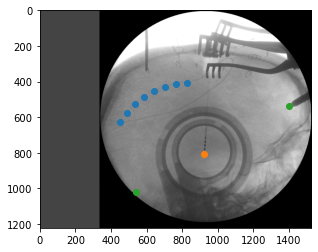

In [5]:
import matplotlib.pyplot as plt
plt.imshow(fluoro,cmap='gray')
plt.scatter(coords_dict['ecog'][:,0], coords_dict['ecog'][:,1])
plt.scatter(coords_dict['dbs'][0], coords_dict['dbs'][1])
plt.scatter(coords_dict['pin'][:,0], coords_dict['pin'][:,1])

## STEP 2: SEGMENT FROM CT

In [6]:
from tiger import ct_get_landmarks
coords3d_dic = ct_get_landmarks(prect_data, postct_data)
pins_ct = coords3d_dic['pin']

Tiger.py successfully executed.


### Visual Check

In [7]:
from mayavi import mlab
mlab.init_notebook()
fig = mlab.figure(bgcolor=(1, 1, 1), size=(500, 500))
source_1 = mlab.pipeline.scalar_field(prect_data)
surface = mlab.pipeline.iso_surface(source_1, 
                          contours=[256,], 
                          opacity=0.5, 
                          colormap = 'black-white')

source_2 = mlab.pipeline.scalar_field(postct_data[:,:128,:])
surface = mlab.pipeline.iso_surface(source_2, 
                          contours=[256,], 
                          opacity=0.8, 
                          colormap = 'black-white')
mlab.points3d(pins_ct[:,0],pins_ct[:,1],pins_ct[:,2], color = (0.2,1,.2), scale_factor=10)

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…

## STEP 3: MAP TO 2D

When converting from pixel to 3d coordinate mayavi just centers x and y, so (1400,1200) image will have a center at (700,600) and possibly x and y switched

In [8]:
## landmarks 1
landmarks1 = np.array([
coords3d_dic['lead'][1:3],
coords3d_dic['pin'][0,1:3],
coords3d_dic['pin'][1,1:3]])

In [9]:
from utils import mayavi_transform

In [10]:
# landmarks 2
landmarks2= np.array([
mayavi_transform(coords_dict['dbs']-(np.array(fluoro.shape[0])/2),
                fluoro.shape),
mayavi_transform(coords_dict['pin'][0],
                fluoro.shape),
mayavi_transform(coords_dict['pin'][1],
                fluoro.shape)])

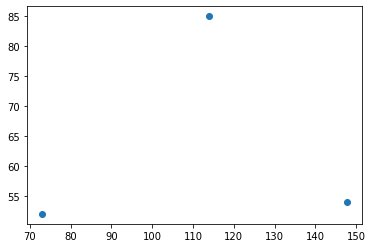

In [11]:
plt.scatter(landmarks1[:,0], landmarks1[:,1])

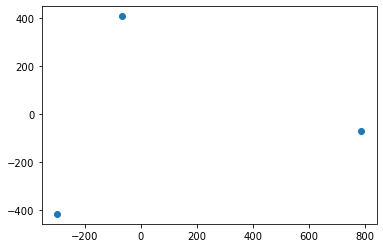

In [12]:
plt.scatter(landmarks2[:,0], landmarks2[:,1])

In [13]:
from micah import project_to_2d
aligned_coords = project_to_2d(prect_data, postct_data, fluoro,  coords3d_dic['pin'], coords_dict['ecog'])

Micah.py successfully executed.


### Visual Inspect

In [14]:
aligned_coords

array([[149.,  77.],
       [143.,  75.],
       [137.,  76.],
       [132.,  77.],
       [127.,  78.]])

## STEP 4: MAP TO 3D

In [15]:
from milos import project_to_3d
predictions = project_to_3d(aligned_coords, points_hull)

Milos.py successfully executed.


### Visual Inspect

In [16]:
predictions

array([[149.,  77., 100.],
       [143.,  75., 101.],
       [137.,  76., 102.],
       [132.,  77., 103.],
       [127.,  78., 104.]])

## Grouth Truth

In [17]:
scipy.io.loadmat("DBS_bT20/Electrode_Locations_JWC/electrode_locs.mat")

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Aug 28 22:35:58 2020',
 '__version__': '1.0',
 '__globals__': [],
 'CortElecLoc': array([[array([[ 48.88512421, -73.83932495,  21.71887207]]),
         array([[ 45.88512421, -68.83932495,  28.71887207]]),
         array([[ 44.88512421, -62.83932495,  34.71887207]]),
         array([[ 44.88512421, -55.83932495,  40.71887207]]),
         array([[ 45.88512421, -47.83932495,  44.71887207]]),
         array([[ 42.88512421, -39.83932495,  47.71887207]]),
         array([[ 39.88512421, -31.83932495,  50.71887207]]),
         array([[ 43.88512421, -21.83932495,  51.71887207]])]],
       dtype=object)}